# Algoritmo ALS para Recomendação On-line

Referência:

http://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering

http://www.slideshare.net/srowen/big-practical-recommendations-with-alternating-least-squares


## Objetivo

Entender a dinâmica do cálculo do ALS, testar alternativas para inicialização dos vetores de fatores latentes para novos usuários e novos documentos, testar alternativas para execução incremental do ALS.

In [1]:
using Gadfly
using DataFrames
set_default_plot_size(24cm, 16cm)

In [2]:
u = 1000 # Number of Users
i = 50   # Number of Items
d = 0.03 # Density of Preferences (3%) 
m = 10.0 # Max Preference value

println("Number of users: $u")
println("Number of itens: $i")
println("Density of preferences: $d")
println("Max preferences value: $m")

Number of users: 1000
Number of itens: 50
Density of preferences: 0.03
Max preferences value: 10.0


In [3]:
# random preferences (uniform distribution), users (lines) vs. items (columns)
A = rand(u,i)

1000x50 Array{Float64,2}:
 0.78919    0.589389   0.0578251  …  0.546003   0.746442   0.755104  
 0.141481   0.728367   0.856678      0.0342646  0.106533   0.261242  
 0.439392   0.734299   0.214151      0.570165   0.917008   0.552105  
 0.568106   0.163773   0.0591229     0.272328   0.0544505  0.00123726
 0.247977   0.982255   0.151696      0.560482   0.374859   0.44337   
 0.55104    0.878484   0.0748678  …  0.378601   0.145123   0.414471  
 0.925623   0.439732   0.418783      0.23748    0.548248   0.619732  
 0.25223    0.582822   0.0374459     0.316653   0.378912   0.270343  
 0.0810157  0.333908   0.909691      0.285246   0.0415169  0.147185  
 0.050295   0.999616   0.68883       0.130275   0.735877   0.515722  
 0.54906    0.382812   0.573746   …  0.148083   0.31257    0.489636  
 0.688844   0.681692   0.0431329     0.971655   0.637413   0.704242  
 0.36702    0.327701   0.550585      0.696479   0.687086   0.351703  
 ⋮                                ⋱                             

In [4]:
# binary matrix (A is 0-1 uniform, so number of trues is equal to 'd' percentage)  
B = A .< d

1000x50 BitArray{2}:
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false   true
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false  …  false   true  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
     ⋮                        

In [5]:
# clean preferences (remove preferences above d)
C = A .* float(B)

1000x50 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0        0.0  0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0        0.0  0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0        0.0  0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0        0.0  0.00123726
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0        0.0  0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0        0.0  0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0        0.0  0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0        0.0  0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0        0.0  0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0        0.0  0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0        0.0  0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0        0.0  0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0        0.

In [6]:
# scale preferences (all values are below d and scaled to max m)
P = ceil(C * m / d)

1000x50 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  8.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

Number of Preferences: 1459


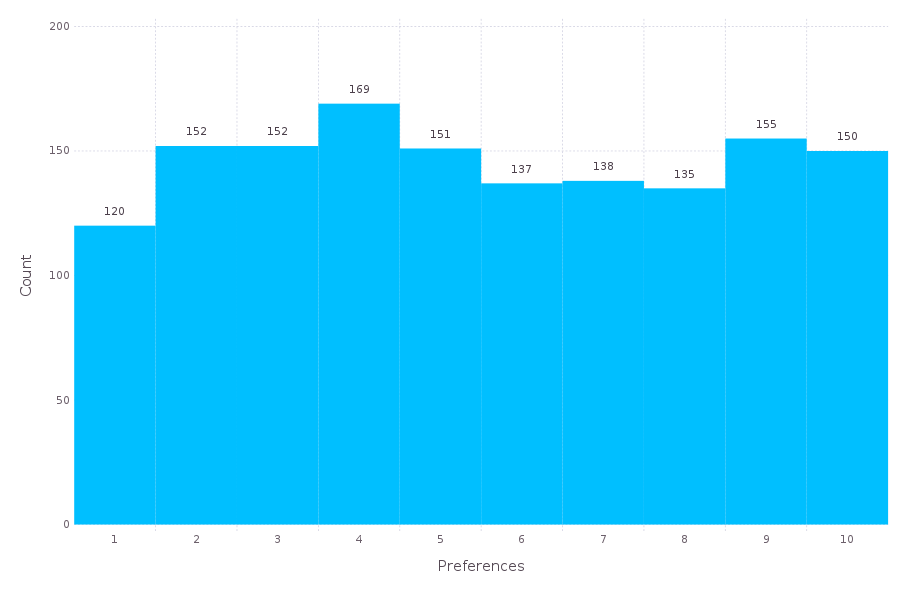

In [7]:
prefs = filter(v -> v != 0.0, P)
prefs = ifloor(prefs)

prefs_n = length(prefs)
bins = iceil(m)
x, y = hist(prefs, bins)

x = int(collect(x)[2:end])
x = map(string, x)

prefs_df = DataFrame(Preferences=x, Count=y, Label=map(string, y))
println("Number of Preferences: $prefs_n")
plot(prefs_df,
    x="Preferences",
    y="Count",
    label="Label",
    Geom.label(position=:above),
    Geom.bar,
    Scale.y_continuous(minvalue=0))

In [8]:
# users summary

s(t) = symbol(t)

function user_stats(U)
    items = length(U)
    pref_max = maximum(U)
    pref_min = minimum(U)
    pref_mean = mean(U)
    {
        s("Number Of Items") => items,
        s("Min Preference") => pref_min,
        s("Max Preference") => pref_max,
        s("Mean Preference") => pref_mean,
    }
end

users_prefs = [ filter(v -> v != 0.0, P[k,:]) for k in 1:size(P,1) ]
users_prefs = filter(v -> length(v) > 0, users_prefs)
users_stats = [ user_stats(U) for U in users_prefs ]

users_df = DataFrame(users_stats)
users_n = nrow(users_df)

println("Number of Users: $users_n")
println()
describe(users_df)

Number of Users: 776

Max Preference
Min      1.0
1st Qu.  5.0
Median   7.0
Mean     6.65979381443299
3rd Qu.  9.0
Max      10.0
NAs      0
NA%      0.0%

Number Of Items
Min      1.0
1st Qu.  1.0
Median   2.0
Mean     1.8801546391752577
3rd Qu.  2.0
Max      7.0
NAs      0
NA%      0.0%

Min Preference
Min      1.0
1st Qu.  2.0
Median   4.0
Mean     4.396907216494846
3rd Qu.  6.0
Max      10.0
NAs      0
NA%      0.0%

Mean Preference
Min      1.0
1st Qu.  4.0
Median   5.5
Mean     5.526135247913598
3rd Qu.  7.0
Max      10.0
NAs      0
NA%      0.0%



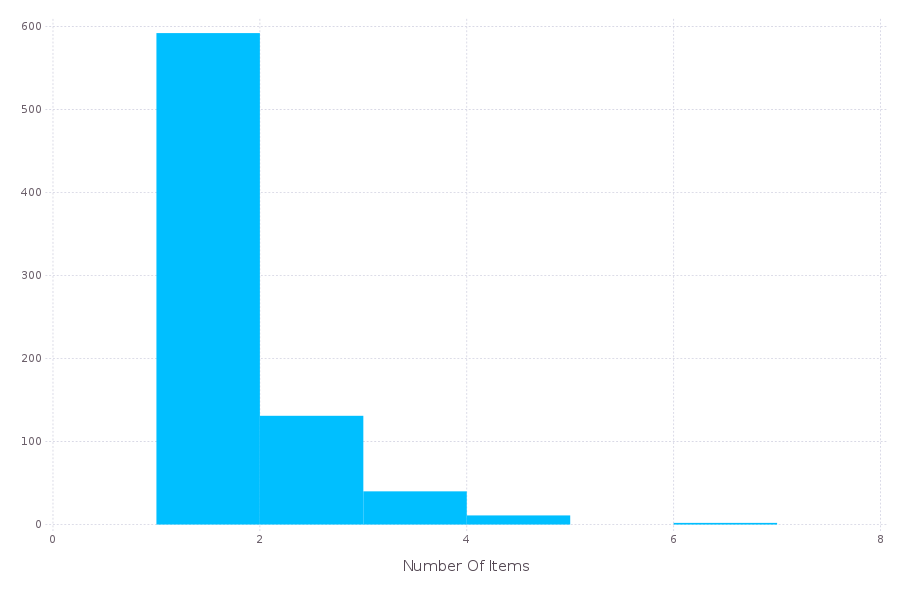

In [9]:
bins = maximum(users_df[s("Number Of Items")]) - minimum(users_df[s("Number Of Items")]) + 1
plot(users_df, x="Number Of Items", Geom.histogram(bincount=bins))

In [10]:
# items summary

function item_stats(I)
    users = length(I)
    pref_max = maximum(I)
    pref_min = minimum(I)
    pref_mean = mean(I)
    {
        s("Number Of Users") => users,
        s("Min Preference") => pref_min,
        s("Max Preference") => pref_max,
        s("Mean Preference") => pref_mean,
    }
end

items_prefs = [ filter(v -> v != 0.0, P[:,k]) for k in 1:size(P,2) ]
items_prefs = filter(v -> length(v) > 0, items_prefs)
items_stats = [ item_stats(I) for I in items_prefs ]

items_df = DataFrame(items_stats)

items_n = nrow(items_df)

println("Number of Items: $items_n")
println()
describe(items_df)

Number of Items: 50

Max Preference
Min      9.0
1st Qu.  10.0
Median   10.0
Mean     9.96
3rd Qu.  10.0
Max      10.0
NAs      0
NA%      0.0%

Number Of Users
Min      16.0
1st Qu.  25.25
Median   28.5
Mean     29.18
3rd Qu.  32.0
Max      47.0
NAs      0
NA%      0.0%

Min Preference
Min      1.0
1st Qu.  1.0
Median   1.0
Mean     1.1
3rd Qu.  1.0
Max      2.0
NAs      0
NA%      0.0%

Mean Preference
Min      4.552631578947368
1st Qu.  5.221590909090909
Median   5.516666666666667
Mean     5.546311502375609
3rd Qu.  5.842948717948717
Max      6.758620689655173
NAs      0
NA%      0.0%



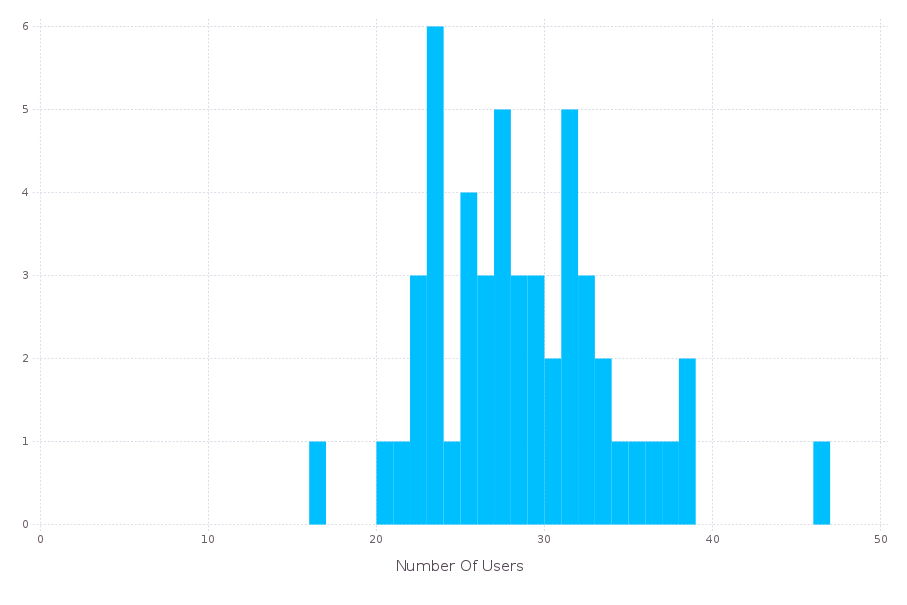

In [11]:
bins = maximum(items_df[s("Number Of Users")]) - minimum(items_df[s("Number Of Users")]) + 1
plot(items_df, x="Number Of Users", Geom.histogram(bincount=bins))

In [12]:
function mse(P, X, Y)
    E = P - X * Y'
    E2 = E .^ 2
    mean(E2)
end

function als_plain(P, n_factors, n_iterations, λ)
    n_users, n_items = size(P)
    
    errors = Array(Float64, n_iterations)

    X = rand(n_users, n_factors)
    Y = rand(n_items, n_factors)

    reg = λ * eye(n_factors)
    for i in 1:n_iterations
        X = ((Y' * Y + reg) \ (Y' * P'))'
        Y = ((X' * X + reg) \ (X' * P))'
        errors[i] = mse(P, X, Y)
    end

    X, Y, errors
end

als_plain (generic function with 1 method)

In [13]:
#factors = [10, 20, 100] 
#iterations = [5, 15, 50]
factors = [10, 20, 100]
iterations = [10]
lambdas = [0.01, 0.1, 1.0] 

testcases = vec([(f,i,λ) for f in factors, i in iterations, λ in lambdas])

new_result() = DataFrame([
    Int,     # Factors
    Int,     # Iterations
    Float64, # Lambda
    Float64, # Alpha
    Float64, # Last Error
    Float64, # Min Error
    Float64  # Max Error
    ], [
    :Factors,
    :Iterations,
    :λ,
    :α,
    :LastError,
    :MinError,
    :MaxError
], 0)

new_result (generic function with 1 method)

 10, I=10, λ=0.01 elapsed time: 1.812772988 seconds (59145968 bytes allocated, 7.30% gc time)
 20, I=10, λ=0.01 elapsed time: 0.034599343 seconds (17429448 bytes allocated)
 100, I=10, λ=0.01 elapsed time: 0.128742385 seconds (43027960 bytes allocated, 54.62% gc time)
 10, I=10, λ=0.1 elapsed time: 0.052832515 seconds (14677992 bytes allocated)
 20, I=10, λ=0.1 elapsed time: 0.110128044 seconds (17429448 bytes allocated, 64.74% gc time)
 100, I=10, λ=0.1 elapsed time: 0.159908944 seconds (43027976 bytes allocated, 45.01% gc time)
 10, I=10, λ=1.0 elapsed time: 0.039674075 seconds (14677992 bytes allocated)
 20, I=10, λ=1.0 elapsed time: 0.021007344 seconds (17429448 bytes allocated)
 100, I=10, λ=1.0 elapsed time: 0.134935162 seconds (43027976 bytes allocated, 52.79% gc time)
9x7 DataFrame
| Row | Factors | Iterations | λ    | α   | LastError   | MinError    |
|-----|---------|------------|------|-----|-------------|-------------|
| 1   | 100     | 10         | 0.01 | 0.0 | 1.19609e-6 

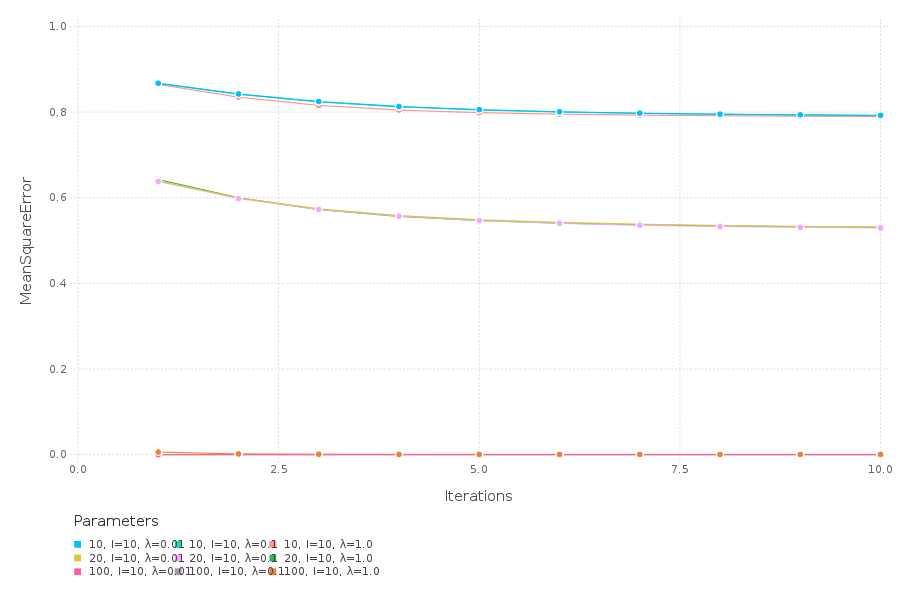

In [14]:
result = new_result()

g = Array(Layer, 0)

for (f, i, λ) in testcases
    params = " $f, I=$i, λ=$λ "
    print(params)

    @time _, _, errors = als_plain(P, f, i, λ)

    last = errors[i]
    min = minimum(errors)
    max = maximum(errors)

    push!(result, [f, i, λ, 0.0, last, min, max])
            
    params = " $f, I=$i, λ=$λ "
    df = DataFrame(Iterations=1:i, MeanSquareError=errors, Parameters=params)
    pl = layer(df, x=:Iterations, y=:MeanSquareError, color=:Parameters, Geom.line, Geom.point)
    push!(g, pl...)
end

sort!(result, cols = :MinError)

println(result)

plot(g, Theme(key_position=:bottom))

In [15]:
function als_weighted(P, n_factors, n_iterations, λ)
    n_users, n_items = size(P)
    
    errors = Array(Float64, n_iterations)

    X = rand(n_users, n_factors)
    Y = rand(n_items, n_factors)
    
    W = float(P .> 0.0)
    Wu = [diagm(vec(W[k,:])) for k in 1:n_users]
    Wi = [diagm(W[:,k]) for k in 1:n_items]
    
    Pu = [vec(P[k,:]) for k in 1:n_users]
    Pi = [P[:,k] for k in 1:n_items]
    
    reg = λ * eye(n_factors)
    for i in 1:n_iterations
        for k in 1:n_users
            Wuk = Wu[k]
            X[k,:] = ((Y' * Wuk * Y + reg) \ (Y' * Wuk * Pu[k]))'
        end
        for k in 1:n_items
            Wik = Wi[k]
            Y[k,:] = ((X' * Wik * X + reg) \ (X' * Wik * Pi[k]))'
        end
        errors[i] = mse(P, X, Y)
    end

    X, Y, errors
end

als_weighted (generic function with 1 method)

 10, I=10, λ=0.01 elapsed time: 5.138037608 seconds (817606796 bytes allocated, 5.12% gc time)
 20, I=10, λ=0.01 elapsed time: 6.305731216 seconds (1198629480 bytes allocated, 20.09% gc time)
 100, I=10, λ=0.01 elapsed time: 22.533360544 seconds (6045707208 bytes allocated, 38.17% gc time)
 10, I=10, λ=0.1 elapsed time: 6.376298041 seconds (804497560 bytes allocated, 4.65% gc time)
 20, I=10, λ=0.1 elapsed time: 7.420231576 seconds (1198629480 bytes allocated, 16.77% gc time)
 100, I=10, λ=0.1 elapsed time: 22.294979729 seconds (6045707192 bytes allocated, 37.91% gc time)
 10, I=10, λ=1.0 elapsed time: 4.41532693 seconds (804497544 bytes allocated, 6.66% gc time)
 20, I=10, λ=1.0 elapsed time: 6.546639325 seconds (1198629496 bytes allocated, 19.55% gc time)
 100, I=10, λ=1.0 elapsed time: 20.54133121 seconds (6045707224 bytes allocated, 39.94% gc time)
9x7 DataFrame
| Row | Factors | Iterations | λ    | α   | LastError | MinError | MaxError |
|-----|---------|------------|------|-----|

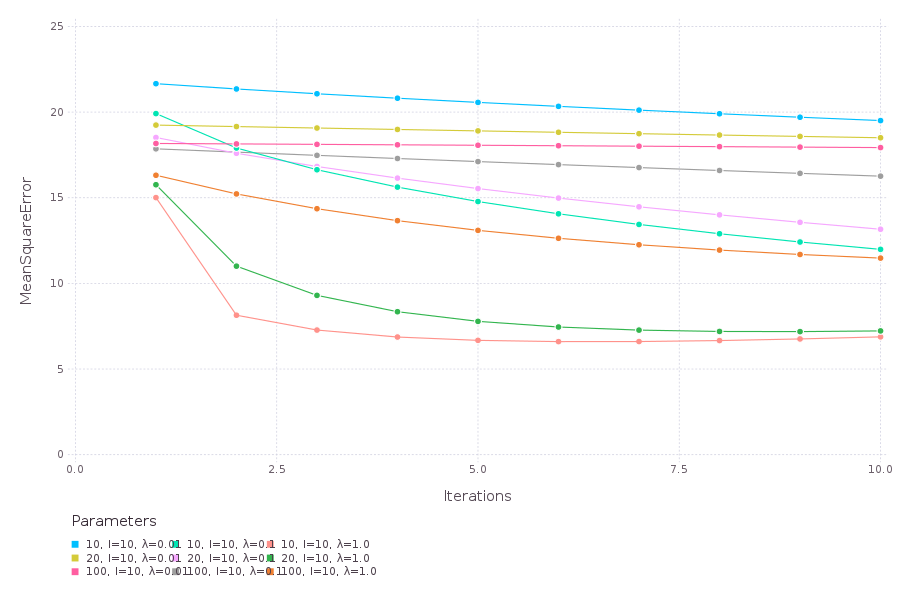

In [16]:
result = new_result()

g = Array(Layer, 0)

for (f, i, λ) in testcases
    params = " $f, I=$i, λ=$λ "
    print(params)
    
    @time _, _, errors = als_weighted(P, f, i, λ)

    last = errors[i]
    min = minimum(errors)
    max = maximum(errors)

    push!(result, [f, i, λ, 0.0, last, min, max])

    df = DataFrame(Iterations=1:i, MeanSquareError=errors, Parameters=params)
    pl = layer(df, x=:Iterations, y=:MeanSquareError, color=:Parameters, Geom.line, Geom.point)
    push!(g, pl...)
end

sort!(result, cols = :MinError)

println(result)

plot(g, Theme(key_position=:bottom))

In [17]:
function als_implicit(R, n_factors, n_iterations, λ, α)
    n_users, n_items = size(R)
    
    errors = Array(Float64, n_iterations)

    X = rand(n_users, n_factors)
    Y = rand(n_items, n_factors)
    
    P = float(R .> 0.0)

    C = P + α * R
    Cu = [diagm(vec(C[k,:])) for k in 1:n_users]
    Ci = [diagm(C[:,k]) for k in 1:n_items]
    
    Pu = [vec(P[k,:]) for k in 1:n_users]
    Pi = [P[:,k] for k in 1:n_items]
    
    reg = λ * eye(n_factors)
    for i in 1:n_iterations
        for k in 1:n_users
            Cuk, Puk = Cu[k], Pu[k]
            X[k,:] = ((Y' * Cuk * Y + reg) \ (Y' * Cuk * Puk))'
        end
        for k in 1:n_items
            Cik, Pik = Ci[k], Pi[k]
            Y[k,:] = ((X' * Cik * X + reg) \ (X' * Cik * Pik))'
        end
        errors[i] = mse(P, X, Y)
    end

    X, Y, errors
end

als_implicit (generic function with 1 method)

 10, I=20, λ=50.0, α=0.0 elapsed time: 8.548031495 seconds (1183916388 bytes allocated, 3.15% gc time)
 10, I=20, λ=100.0, α=0.0 elapsed time: 8.631326644 seconds (1178787576 bytes allocated, 4.43% gc time)
 10, I=20, λ=200.0, α=0.0 elapsed time: 8.859398984 seconds (1178787576 bytes allocated, 3.23% gc time)
 10, I=20, λ=50.0, α=0.01 elapsed time: 8.552324179 seconds (1178787576 bytes allocated, 3.90% gc time)
 10, I=20, λ=100.0, α=0.01 elapsed time: 8.944505789 seconds (1178787576 bytes allocated, 3.32% gc time)
 10, I=20, λ=200.0, α=0.01 elapsed time: 8.358367586 seconds (1178787592 bytes allocated, 3.37% gc time)
 10, I=20, λ=50.0, α=0.1 elapsed time: 8.499014601 seconds (1178787624 bytes allocated, 3.42% gc time)
 10, I=20, λ=100.0, α=0.1 elapsed time: 8.515033277 seconds (1178787592 bytes allocated, 3.31% gc time)
 10, I=20, λ=200.0, α=0.1 elapsed time: 8.597546258 seconds (1178787576 bytes allocated, 3.36% gc time)
 10, I=20, λ=50.0, α=1.0 elapsed time: 9.032168582 seconds (1178

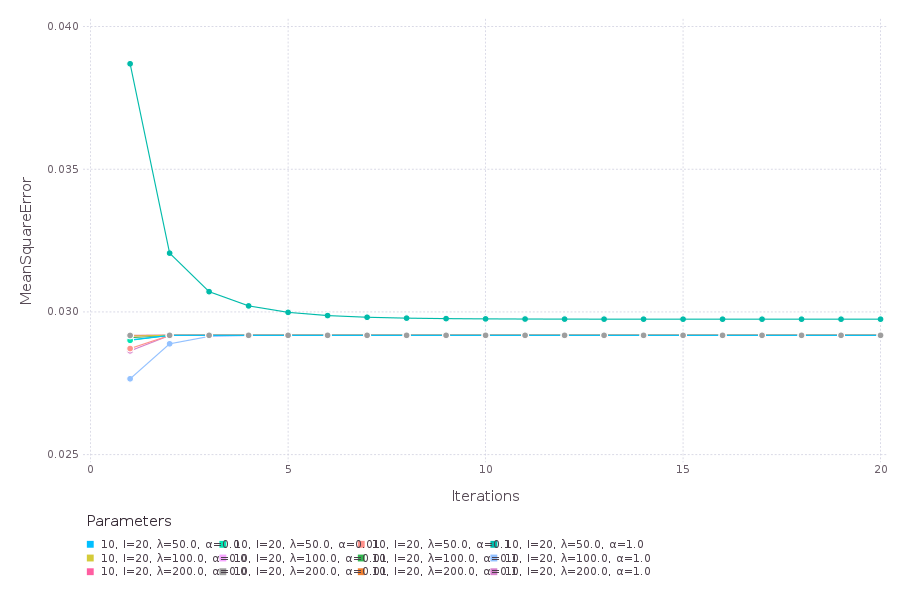

In [18]:
result = new_result()

g = Array(Layer, 0)

implicit_tests = vec([(f,20,λ,α) for f in 10, λ in [50.,100.,200.], α in [0.,0.01,0.1,1.0]])

for (f, i, λ, α) in implicit_tests
    params = " $f, I=$i, λ=$λ, α=$α "
    print(params)
    
    @time _, _, errors = als_implicit(P, f, i, λ, α)

    last = errors[i]
    min = minimum(errors)
    max = maximum(errors)

    push!(result, [f, i, λ, α, last, min, max])

    df = DataFrame(Iterations=1:i, MeanSquareError=errors, Parameters=params)
    pl = layer(df, x=:Iterations, y=:MeanSquareError, color=:Parameters, Geom.line, Geom.point)
    push!(g, pl...)
end

sort!(result, cols = :LastError)

println(result)

plot(g, Theme(key_position=:bottom))